In [3]:
import re
import numpy as np
import pandas as pd
import os
from os import walk
import math

import cv2 as cv
import networkx as nx

import chart_studio.plotly as py
import plotly.offline as py
import plotly.graph_objects as go
import matplotlib.pyplot as plt
#from Shapes import shapes
#from Lines import lines


In [225]:
from ipywidgets import interact

### Pulling in Data

In [4]:
file_path = '/Users/agetecza/CAM_Data/AT_CAM/Data/Clean' #path to data on local computer

In [5]:
#Function to get unique elements from a list
def list_unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
            
    return unique_list

In [6]:
def make_id_list(my_file_path):

    #pull all filenames in your data directory
    _, _, filenames = next(walk(my_file_path))

    #grab only the id from the filenames to feed to the function
    id_list = []
    for filename in filenames:
        filename_split = filename.rsplit('_', 1)
        id_list.append(filename_split[0])
    
    unique_id = list_unique(id_list) #drop duplicate ids, since they are the same for _blocks & _links
        
    
    
    return unique_id

In [7]:
#Get an id_list from your specific file path
my_id_list = make_id_list(file_path)

In [8]:
#Look at total number of cams
len(my_id_list)

159

### Looking at a single CAM

In [238]:
cam_id = my_id_list[6] #grab a single id to just look through code

blocks = pd.read_csv(f'{file_path}/{cam_id}_blocks.csv')
links = pd.read_csv(f'{file_path}/{cam_id}_links.csv')

display(blocks.head())
display(links.head())

,id,title,x_pos,y_pos,width,height,shape,creator,num,comment,timestamp,modifiable,CAM
0,13781,Carbon tax,455.0,310.0,160.0,120.0,neutral,749,1.0,NaN,NaN,1,857
1,13817,subsidies,77.0,290.0,160.0,120.0,negative,749,2.0,NaN,18:12:32,1,857
2,13825,taxes,196.0,65.0,160.0,120.0,negative,749,3.0,NaN,18:12:21,1,857
3,13828,jobs,578.0,94.0,160.0,120.0,positive weak,749,4.0,NaN,NaN,1,857
4,13858,environment,729.0,276.0,160.0,120.0,positive,749,5.0,NaN,NaN,1,857


,id,starting_block,ending_block,line_style,creator,num,arrow_type,timestamp,CAM
0,8168,13781,13828,Dashed-Weak,749,0,none,18:18:09,857
1,8182,13781,13869,Dashed,749,0,none,18:18:54,857
2,8206,13781,13817,Solid,749,0,none,18:20:22,857
3,8211,13781,13825,Solid-Weak,749,0,none,18:20:29,857
4,8188,13781,13858,Solid-Weak,749,0,none,18:19:06,857


## Create A Graph Using Networkx

### Create a function to build most basic graph

In [11]:
def graph_from_df(node_df, edge_df):
    # Get nodes
    nodes = node_df['id'].to_list()
    
    # Get edges
    edge_start = edge_df['starting_block'].to_list()
    edge_end = edge_df['ending_block'].to_list()
    edges = tuple(zip(edge_start, edge_end))
    
    # Create Graph
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

In [12]:
G = graph_from_df(blocks,links)

### Create a function to add attributes 

In [13]:
def add_node_attributes(graph_name, node_df, attr_name): #attr_column_name must be in quotes
    
    blocks_dict = node_df[['id', attr_name]].set_index('id').to_dict()[attr_name]
    
    nx.set_node_attributes(graph_name, blocks_dict, attr_name)
    

In [14]:
def add_link_attributes(graph_name, edge_df, attr_name):
    attr_full_dict = {}
    
    edge_df['unique_link']= list(zip(edge_df['starting_block'], edge_df['ending_block']))
        
    for idx, row in edge_df.iterrows():
        
        attr_dict = {attr_name: row[attr_name]}
        
        attr_full_dict.update({row['unique_link']:attr_dict})
    
    nx.set_edge_attributes(G, attr_full_dict)
    
    
    

### Make all the Graphs
#### Store all graphs with attributes in a list

In [15]:
graph_list = []
working_id = []
no_data = []
missing_cam = []

for i in my_id_list:
    
    
    try:
        blocks_df = pd.read_csv(f'{file_path}/{i}_blocks.csv')

        links_df = pd.read_csv(f'{file_path}/{i}_links.csv')
        
        if len(links_df)>0:

            G = graph_from_df(blocks_df, links_df)

            add_node_attributes(G,blocks_df,'title')

            add_node_attributes(G,blocks_df,'shape')

            add_link_attributes(G, links_df, 'line_style')

            graph_list.append(G)
            
            working_id.append(i)

        
        else:
            no_data.append(i)
    
    except:
        
        missing_cam.append(i)
        print(f'CAM {i} does not exist')

print('Summary Info:')
print(f'number of missing cams: {len(missing_cam)}')
print(f'number of cams with no links: {len(no_data)}')
print(f'number of complete cams: {len(working_id)}')


CAM 575ec4be3fc3ac000611df4c__771 does not exist
Summary Info:
number of missing cams: 1
number of cams with no links: 32
number of complete cams: 126


#### Look at one of the graphs stored in your graph list

[(13488, 13519, {'line_style': 'Solid-Strong'}), (13488, 13480, {'line_style': 'Dashed'}), (13480, 13510, {'line_style': 'Solid-Weak'}), (13480, 13485, {'line_style': 'Solid-Weak'}), (13480, 13519, {'line_style': 'Solid'}), (13480, 13537, {'line_style': 'Solid-Strong'}), (13480, 13545, {'line_style': 'Solid-Weak'}), (13480, 13558, {'line_style': 'Solid-Weak'}), (13485, 13510, {'line_style': 'Solid-Strong'}), (13485, 13558, {'line_style': 'Solid'}), (13545, 13537, {'line_style': 'Solid-Strong'})]
-------------------------
[(13488, {'title': 'Backlash from scary conservatives', 'shape': 'negative weak'}), (13480, {'title': 'Carbon Tax', 'shape': 'neutral'}), (13485, {'title': 'makes people more enviromentally concious', 'shape': 'positive weak'}), (13510, {'title': 'Fresher air', 'shape': 'positive strong'}), (13519, {'title': 'Price of goods could go up', 'shape': 'negative weak'}), (13545, {'title': 'More social service/ environment jobs', 'shape': 'positive weak'}), (13537, {'title': 

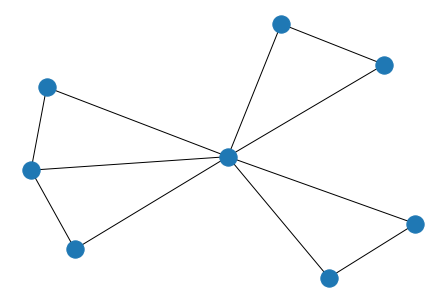

In [16]:
my_graph = graph_list[1]

nx.draw(my_graph)
print(my_graph.edges(data = True))
print('-------------------------')
print(my_graph.nodes(data = True))


# Simulations

### assumption: graph probability distribution is uniform, conditioned on size and density
 (all graphs of given size and density are equally probable)

G n,M = graph of size n, with M links 
Sample procedure:
create an empty graph with n vertices and randomly insert M links from n(n-1) possible links without replacement

### Function to make data frame of GLI for all CAMs

In [245]:
def calc_CAM_GLI(id_list):
    positive_list = ['positive strong', 'positive','positive weak']
    negative_list = ['negative strong','negative','negative weak']
    neutral_list = ['neutral','ambivalent']
    
    dictionary_list = []
    
    for cam_id in id_list:
        block_neg = 0
        block_pos = 0
        block_neut = 0
        
        try:
            df_blocks = pd.read_csv(f'{file_path}/{cam_id}_blocks.csv')
            df_links = pd.read_csv(f'{file_path}/{cam_id}_links.csv')
            
            #Get proportion of positive and negative nodes
            for i in range(len(df_blocks)):
                if df_blocks['shape'][i] in negative_list:
                    block_neg = block_neg + 1
                elif df_blocks['shape'][i] in positive_list:
                    block_pos = block_pos + 1
                else:
                    block_neut = block_neut + 1
        

            # Get nodes
            nodes = df_blocks['id'].to_list()
            
            # Get edges
            edge_start = df_links['starting_block'].to_list()
            edge_end = df_links['ending_block'].to_list()
            edges = tuple(zip(edge_start, edge_end))
            
            # Create Graph
            G = nx.Graph()
            G.add_nodes_from(nodes)
            G.add_edges_from(edges)
            
            # Calculate Density
            density = np.round(nx.density(G), 3)
            node_count = G.number_of_nodes()
            edge_count = G.size()
            
            # Calculate longest path
            try:
                components = nx.connected_components(G)
                largest_component = max(components, key=len)
                subgraph = G.subgraph(largest_component)
                diameter = nx.diameter(subgraph)
            except:
                diameter = 0
            # Calculate transitivity
            triadic_closure = np.round(nx.transitivity(G), 3)
            
            # Calculate max degree
            try:
                degree_centrality = nx.degree_centrality(G)
                max_centrality_ind = np.argmax(list(degree_centrality.values()))
                central_node = list(degree_centrality.keys())[max_centrality_ind]
                central_node_title = df_blocks[df_blocks['id'] == central_node]['title'].values[0]
                central_node_val = np.round(list(degree_centrality.values())[max_centrality_ind], 3)
            except:
                central_node = 0
                central_node_title = ''
                central_node_val = 0
                
            # Eigenvector Centrality
            try:
                eigenvector_centrality = nx.eigenvector_centrality(G)
                max_centrality_ind = np.argmax(list(eigenvector_centrality.values()))
                central_node_val_eig = np.round(list(eigenvector_centrality.values())[max_centrality_ind], 3)
            except:
                central_node_val_eig = 0
                
            # Betweeness Centrality
            try:
                betweenness_centrality = nx.betweenness_centrality(G)
                max_centrality_ind = np.argmax(list(betweenness_centrality.values()))
                central_node_val_bet = np.round(list(betweenness_centrality.values())[max_centrality_ind], 3)
            except:
                central_node_val_bet = 0

            # Make the dictionary
                #add in ratio of node val
                #add number of type of node
            density_dict = {
                'cam_id': cam_id,
                'node_count': node_count,
                'positive_nodes':block_pos,
                'negative_nodes':block_neg,
                'neutral_nodes':block_neut,
                'edge_count': edge_count,
                'density': density,
                'diameter': diameter,
                'triadic_closure': triadic_closure,
                'central_node': central_node,
                'central_node_title': central_node_title,
                'central_node_val': central_node_val,
                'central_node_val_eig': central_node_val_eig,
                'central_node_val_bet': central_node_val_bet
            }

            dictionary_list.append(density_dict)
            
        except:
            print(f'No file found for {cam_id}')
        
    cam_density_df = pd.DataFrame(dictionary_list)
            
    return cam_density_df

In [246]:
cam_GLI_df = calc_CAM_GLI(my_id_list)
display(cam_GLI_df)

No file found for 575ec4be3fc3ac000611df4c__771


,cam_id,node_count,positive_nodes,negative_nodes,neutral_nodes,edge_count,density,diameter,triadic_closure,central_node,central_node_title,central_node_val,central_node_val_eig,central_node_val_bet
0,5f32a496a026e809d7d55cbd_817,7,4,1,2,10,0.476,2,0.480,13562,Carbon Tax,1.000,0.595,0.667
1,5f67f8d55e7718150fd23bc7_802,8,5,2,1,11,0.393,2,0.400,13480,Carbon Tax,1.000,0.623,0.786
2,5e45dd10f354ca0c7f4225c7_903,10,3,3,4,9,0.200,5,0.000,14076,economic growth,0.444,0.566,0.722
3,5f4ae6a7ad7baa6aecef4234_990,14,3,8,3,13,0.143,7,0.000,14686,Unequal effect on classes and regions,0.231,0.471,0.667
4,5a4e8f4930adf7000106fd5e_928,12,5,5,2,12,0.182,6,0.000,14279,Financial Burden,0.364,0.470,0.636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,5f57fef7e7b06a35296f215d_822,12,4,4,4,17,0.258,5,0.214,13629,Economy,0.455,0.467,0.544
154,5b0f33dd1e55760001b9a9ce_812,11,6,3,2,22,0.400,3,0.495,13542,Carbon Tax,0.800,0.470,0.369
155,5ca6c9f3a752220001ca1be3_838,9,3,2,4,6,0.167,3,0.333,13693,Carbon Tax,0.500,0.628,0.286
156,5f7dd740074da20008c51bf5_818,7,4,3,0,8,0.381,4,0.400,13566,Carbon Tax,0.667,0.552,0.567


In [19]:
#get a df of the number of cams per node count
node_count_df = pd.DataFrame(cam_GLI_df.groupby('node_count',as_index=False).count()[['node_count','edge_count']]).rename(columns={'edge_count':'cam_count'})
node_count_df.head(5)

,node_count,cam_count
0,0,24
1,1,4
2,2,2
3,3,5
4,4,4


#### Look at distribution of node count

Text(0.5, 1.0, 'Distribution of Node Count')

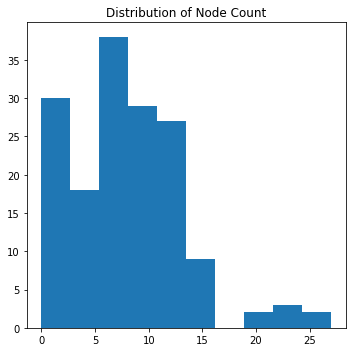

In [21]:
fig, axs = plt.subplots(figsize=(5,5),sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs.hist(cam_GLI_df['node_count'])
axs.set_title('Distribution of Node Count')


### Compare GLI from CAM with what would be expected from chance

### Anderson et al. Approach

In [22]:
col_list = list(cam_GLI_df.columns)
GLI_list = col_list[8:]
GLI_list

['central_node_val', 'central_node_val_eig', 'central_node_val_bet']

In [23]:
print(len(cam_GLI_df))

158


In [229]:
GLI_name = GLI_list[1]

P_H = 0
P_L = 0
P_E = 0
N = 0 

N_max = 100 #number of iterations

alpha = .05 # desired level of significance

condition_list = []
sig_cam_list = []
nonsig_cam_list = []

for i in range(len(cam_GLI_df)):
    
    Obs_GLI = cam_GLI_df[GLI_name][i] #observed GLI from row i

    n = cam_GLI_df['node_count'][i] # number of nodes for cam i
    m = cam_GLI_df['edge_count'][i]  # number of edges for cam i

    while N < N_max:

        # STEP 2: Make the random graph
        G_uni = nx.gnm_random_graph(n, m)


        #Get the necessary GLI measures
        # Calculate Density
        density = np.round(nx.density(G_uni), 3)

        # Calculate longest path
        try:
            components = nx.connected_components(G_uni)
            largest_component = max(components, key=len)
            subgraph = G_uni.subgraph(largest_component)
            diameter = nx.diameter(subgraph)
        except:
            diameter = 0
        # Calculate transitivity
        triadic_closure = np.round(nx.transitivity(G_uni), 3)

        # Calculate max degree
        try:
            degree_centrality = nx.degree_centrality(G_uni)
            max_centrality_ind = np.argmax(list(degree_centrality.values()))
            central_node_val = np.round(list(degree_centrality.values())[max_centrality_ind], 3)
        except:
            central_node_val = 0

        # Eigenvector Centrality
        try:
            eigenvector_centrality = nx.eigenvector_centrality(G_uni)
            max_centrality_ind = np.argmax(list(eigenvector_centrality.values()))
            central_node_val_eig = np.round(list(eigenvector_centrality.values())[max_centrality_ind], 3)
        except:
            central_node_val_eig = 0

        # Betweeness Centrality
        try:
            betweenness_centrality = nx.betweenness_centrality(G_uni)
            max_centrality_ind = np.argmax(list(betweenness_centrality.values()))
            central_node_val_bet = np.round(list(betweenness_centrality.values())[max_centrality_ind], 3)
        except:
            central_node_val_bet = 0

        # Make the dictionary
        G_uni_GLI_dict = {
            'central_node_val': central_node_val,
            'central_node_val_eig': central_node_val_eig,
            'central_node_val_bet': central_node_val_bet
        }

        #STEP 3 - #Maybe issue with have a two conditions with the 'equal to' option
        
        if G_uni_GLI_dict[GLI_name] >= Obs_GLI:
            P_H = P_H + 1

        elif G_uni_GLI_dict[GLI_name] <= Obs_GLI:
            P_L = P_L +1

        #increment N for each iteration till max is reached
        N = N + 1

    #Step 5 - This tests whether the observed GLI is consistently either higher or lower than the GLI predicted
    # by a random graph. 
    condition_1 = (P_H/N_max) < (alpha/2)
    condition_2 = (P_L/N_max) < (alpha/2)
    
    condition_list.append((P_H/N_max,P_L/N_max))

    if condition_1 | condition_2:
        
        sig_cam_list.append(cam_GLI_df['cam_id'][i])
    
    else:
        nonsig_cam_list.append(cam_GLI_df['cam_id'][i])

In [231]:
 len(nonsig_cam_list)

0

#Bays approach to disprove that size impacts 
build random graph with different node size
create likelihood function

G_uni = nx.gnm_random_graph(n, m) density fixed 
G = nx.gnp_random_graph(n,p) density varies


## Add Survey Info to CAM data

In [177]:
file_path_survey = '/Users/agetecza/CAM_Data/AT_CAM/Data/CAM_Survey_Merged.csv'
survey_df = pd.read_csv(file_path_survey)
survey_df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,WilsonPat_5,WilsonPat_6,WilsonPat_7,WilsonPat_8,WilsonPat_9,WilsonPat_10,WilsonPat_11,WilsonPat_12,CheckNum,mTurkCode2
0,2021-01-11 11:46,2021-01-11 11:46,0,50.69.196.183,100,8,1,2021-01-11 11:46,R_2ZQySv7eilk1BhL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-11 11:48,2021-01-11 11:59,0,50.69.196.183,100,660,1,2021-01-11 11:59,R_8erRxEBvfzDsLGp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-11 11:51,2021-01-11 12:01,0,69.158.246.27,100,635,1,2021-01-11 12:01,R_xgzbLgWncp56ACJ,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-11 12:01,2021-01-11 12:13,0,24.212.224.202,100,739,1,2021-01-11 12:13,R_3rOr7B1NkrQgen5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-11 12:04,2021-01-11 12:18,0,24.77.79.89,100,820,1,2021-01-11 12:18,R_1KdKzGSFXHqdKef,NaN,...,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,8165033.0


In [179]:
#drop NAs
survey_df_dropna = survey_df.dropna(subset=['Prolific1','Gender'])

In [247]:
#Get the cam dataframe ready to merge with the survey data
cam_GLI_full = cam_GLI_df.copy()
Prolific1_list=cam_GLI_full['cam_id'].str.split('_').str[0]
cam_GLI_full.insert(loc=0, column='Prolific1', value=Prolific1_list)
cam_GLI_full = cam_GLI_full.drop(cam_GLI_full.columns[1], axis=1)

In [248]:
print(f'The length of cam_df: {len(cam_GLI_full)}')
print(f'The length of survey_df: {len(survey_df_dropna)}')

The length of cam_df: 158
The length of survey_df: 141


In [249]:
survey_cam_merge = pd.merge(cam_GLI_full, survey_df_dropna, how = 'inner', on = 'Prolific1')

In [250]:
print(f'The length of merged data: {len(survey_cam_merge)}')

The length of merged data: 120


## Cleaning the combined dataframe

#### Drop all rows with node_count less than 3 or link_count less than 2

In [251]:
filter_cam = (survey_cam_merge['node_count']>3) & (survey_cam_merge['edge_count']>2)
survey_merge_large_cam = survey_cam_merge[filter_cam]

In [252]:
print(f'{len(survey_merge_large_cam)} rows have more than 3 nodes and more than 2 edges')

113 rows have more than 3 nodes and more than 2 edges


#### Survey checks???

### Select Variables for Analysis

In [464]:
#Get index of different variables to subset df
survey_column_list = list(survey_merge_large_cam.columns)
#survey_column_list

In [357]:
#Check the index of a specific variable
survey_column_list.index('KNRef') 

179

In [358]:
#Get all the controls
control_list_1 = ['Age','Education','Income','English','Gender','CarbFam','CarbSFam']
control_list_Cog = survey_column_list[108:126]
control_list_Aff = survey_column_list[126:152]
control_list_KN = survey_column_list[173:180]

control_list = control_list_1 + control_list_Aff + control_list_Cog + control_list_KN

In [480]:
#Get all variable
network_list = survey_column_list[:14]
dependent_list = ['CarbAg','Interest_1','CarbDecide']
full_variable_list = network_list + dependent_list + control_list

In [481]:
#subset df 

survey_df_analysis = survey_merge_large_cam.loc[:,full_variable_list]

### Descriptives

In [363]:
variable_list = list(survey_df_analysis.columns)

In [364]:
summary_df = pd.DataFrame(survey_df_analysis[variable_list].describe()).transpose()
summary_df

,count,mean,std,min,25%,50%,75%,max
node_count,113.0,9.778761,4.451594,4.0,7.0,9.0,12.0,27.0
positive_nodes,113.0,4.079646,2.431716,0.0,3.0,4.0,5.0,17.0
negative_nodes,113.0,3.398230,2.250158,0.0,2.0,3.0,5.0,11.0
neutral_nodes,113.0,2.176991,1.696794,0.0,1.0,2.0,3.0,11.0
edge_count,113.0,13.469027,8.585776,3.0,8.0,12.0,16.0,63.0
...,...,...,...,...,...,...,...,...
KNPrice,113.0,2.150442,0.585864,1.0,2.0,2.0,3.0,3.0
KNTimes,113.0,1.831858,0.461029,1.0,2.0,2.0,2.0,3.0
KNBC,113.0,2.292035,0.561907,1.0,2.0,2.0,3.0,3.0
KNPerc,113.0,1.964602,0.325390,1.0,2.0,2.0,2.0,3.0


#### Look at correlations & assumption

In [334]:
#Clean up column order
#column_order = list(np.arange(0,21))+list(np.arange(47,50))+list(np.arange(65,68))+list(np.arange(24,47))+list(np.arange(50,65))+list(np.arange(21,24))+list(np.arange(68,72))
#survey_df_arrange = survey_df_analysis.iloc[:,column_order]
#survey_df_arrange.head()

In [505]:
correlation_matrix = survey_df_analysis.corr()

In [507]:
correlation_matrix.iloc[7,5]

0.6966242068223083

In [513]:
corr_df = pd.DataFrame(columns = ['row','column','corr'])
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix)):
        if (correlation_matrix.iloc[i,j]>.6) & (correlation_matrix.iloc[i,j]!=1):
            newrow = {'row':correlation_matrix.columns[i],'column':correlation_matrix.columns[j],'corr':correlation_matrix.iloc[i,j]}
            corr_df = corr_df.append(newrow, ignore_index=True)
            

In [514]:
corr_df

,row,column,corr
0,node_count,positive_nodes,0.759642
1,node_count,negative_nodes,0.738007
2,node_count,edge_count,0.842091
3,positive_nodes,node_count,0.759642
4,positive_nodes,edge_count,0.692700
5,negative_nodes,node_count,0.738007
6,negative_nodes,edge_count,0.607225
7,edge_count,node_count,0.842091
8,edge_count,positive_nodes,0.692700
9,edge_count,negative_nodes,0.607225


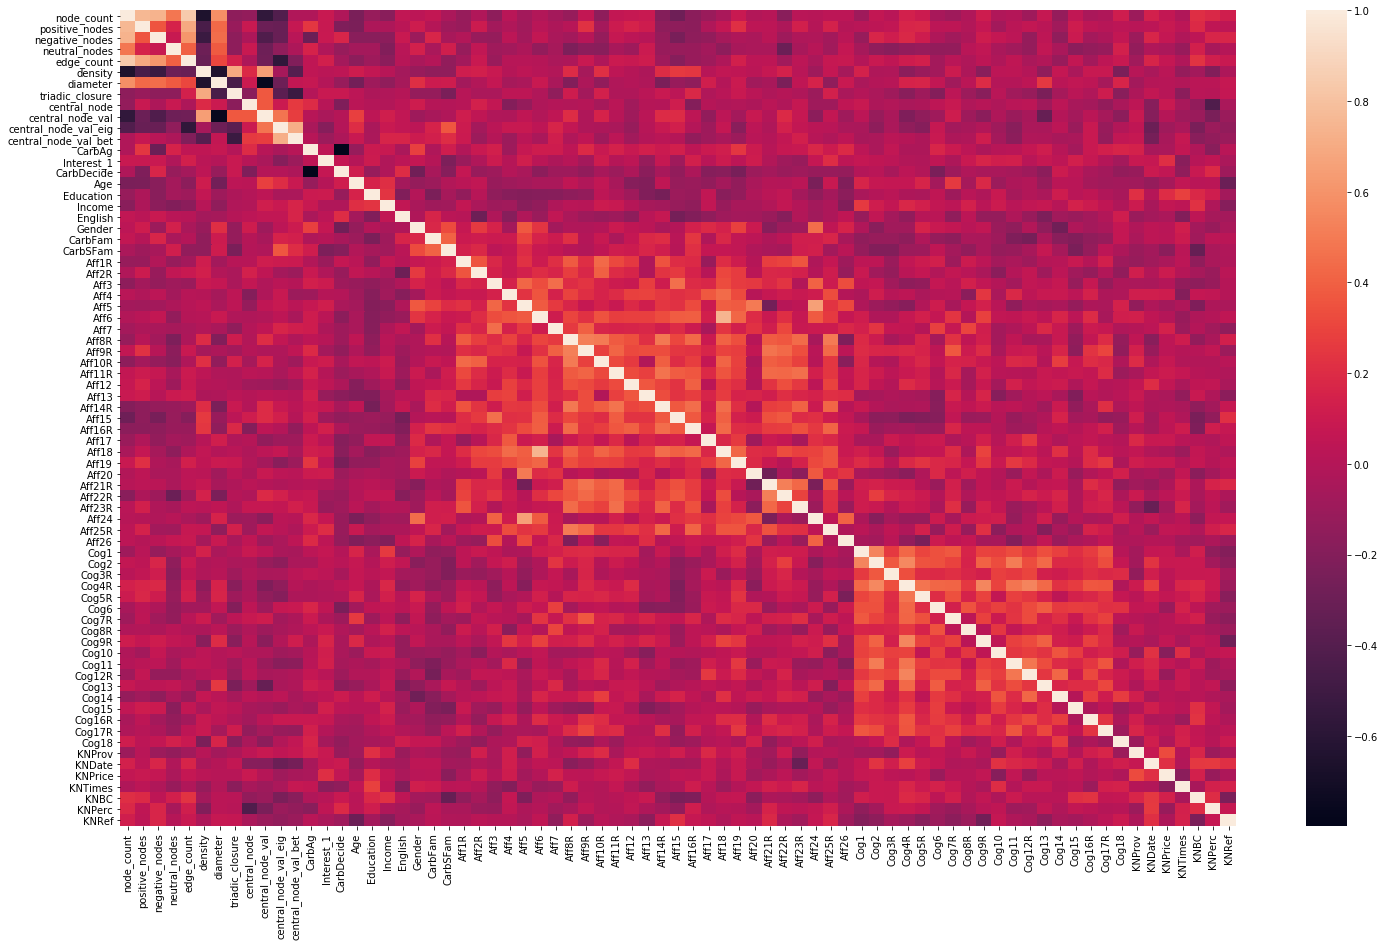

In [365]:
import seaborn as sns
plt.subplots(figsize=(25,15))
sns.heatmap(correlation_matrix)

In [372]:
list(survey_df_analysis.columns).index('Aff1R')

24

In [373]:
Cog_index = list(np.arange(list(survey_df_analysis.columns).index('Cog1'),list(survey_df_analysis.columns).index('Cog18')+1))
Aff_index = list(np.arange(list(survey_df_analysis.columns).index('Aff1R'),list(survey_df_analysis.columns).index('Aff26')+1))
Cog_df = survey_df_analysis.iloc[:,Cog_index]
Aff_df = survey_df_analysis.iloc[:,Aff_index]
Aff_df.head()

,Aff1R,Aff2R,Aff3,Aff4,Aff5,Aff6,Aff7,Aff8R,Aff9R,Aff10R,...,Aff17,Aff18,Aff19,Aff20,Aff21R,Aff22R,Aff23R,Aff24,Aff25R,Aff26
0,3.0,2.0,2.0,4.0,1.0,4.0,2.0,4.0,2.0,5.0,...,2.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0
1,5.0,5.0,4.0,4.0,5.0,5.0,4.0,5.0,5.0,5.0,...,4.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,1.0
2,4.0,5.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,...,5.0,4.0,4.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0
3,2.0,2.0,2.0,4.0,2.0,5.0,3.0,2.0,2.0,2.0,...,3.0,5.0,4.0,2.0,3.0,2.0,2.0,4.0,2.0,3.0
4,4.0,3.0,4.0,4.0,4.0,5.0,2.0,4.0,4.0,4.0,...,5.0,4.0,5.0,2.0,4.0,2.0,4.0,5.0,4.0,1.0


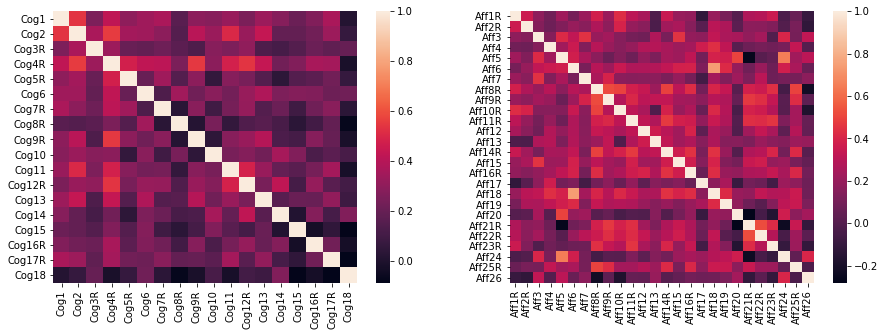

In [374]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

sns.heatmap(Cog_df.corr(), ax=ax1)
sns.heatmap(Aff_df.corr(), ax=ax2)

plt.show()

In [337]:
from sklearn.decomposition import PCA
pca = PCA()
x_pca = pca.fit_transform(Aff_df)
x_pca = pd.DataFrame(x_pca)
x_pca.head(10)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,-0.998527,-2.099164,0.247484,0.786881,0.848016,0.356276,-0.374319,1.782974,2.322172,-1.879677,...,0.203792,-1.404832,1.263023,0.342479,0.168863,-0.482312,-0.178369,0.698179,-0.448622,-0.134951
1,6.070432,0.417127,-0.106831,-0.324235,0.805281,0.696166,-0.204888,0.112795,-0.259254,-1.541977,...,-0.902872,-1.270235,-0.394322,0.073803,0.546282,0.182709,-0.356392,0.166078,0.770530,0.064290
2,1.706088,0.592268,-0.322640,-1.138385,-0.196408,0.245019,-0.233954,-1.196561,-1.651834,1.000101,...,-1.061330,0.414690,0.633683,-0.374603,0.054687,0.171718,-0.201032,-0.637646,-0.290762,0.165876
3,-2.994398,0.029999,1.024141,0.637279,-0.884660,0.728505,-0.273864,0.607414,0.368867,-1.496050,...,0.235591,0.553971,-1.199971,-0.450475,0.306674,-0.853064,0.762599,-0.363496,0.315257,-0.287124
4,2.033459,0.162755,0.675930,1.038966,-0.633405,0.468454,1.627070,-1.058740,-0.447183,-0.339838,...,-0.760516,0.004992,-0.568882,0.872919,-0.059393,0.359210,0.049196,0.092335,0.081522,0.190369
5,-1.588489,-0.118711,-0.564599,0.120610,1.568071,1.117640,0.758239,1.591199,-0.816737,1.024194,...,0.662364,1.024209,0.326302,0.855123,0.105558,0.375715,-0.135418,-0.228467,0.394548,-0.220199
6,2.340773,-0.594462,0.352301,-0.380609,0.328942,-0.154522,0.040636,-0.576545,-0.715439,0.244808,...,0.250212,-0.214502,0.618267,0.237743,0.410267,-0.068793,0.500501,0.976038,0.592110,0.759928
7,-1.745153,0.739598,0.978832,-2.862532,-0.282312,0.064492,-1.699008,-0.274415,0.564842,0.441156,...,-0.800259,-0.784379,0.110064,0.962301,-0.882633,0.332057,0.775299,0.030450,0.044649,-0.512980
8,-3.378809,-1.300982,-1.208913,-0.461198,0.228518,0.724174,-0.681514,-0.644247,-0.733562,0.163602,...,0.442889,0.063182,0.172041,-0.810914,0.221875,0.117530,-1.422442,-0.156117,-0.573611,-0.554361
9,1.799582,-1.466474,-1.093687,-0.698639,-0.717824,-0.050360,-0.313032,0.536436,-0.913137,0.631786,...,0.281192,-0.081150,-0.438071,-1.006090,-0.457765,0.493354,0.810462,0.127524,0.588429,0.812431


In [341]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.28625624, 0.12192773, 0.07518835, 0.06324138, 0.05467244,
       0.04252637, 0.0376069 , 0.03503231, 0.03366536, 0.03040743,
       0.02945067, 0.02613431, 0.0236135 , 0.02054815, 0.01946778,
       0.01924421, 0.01736535, 0.01480754, 0.01344211, 0.01130213,
       0.00936979, 0.00891189, 0.00581805])

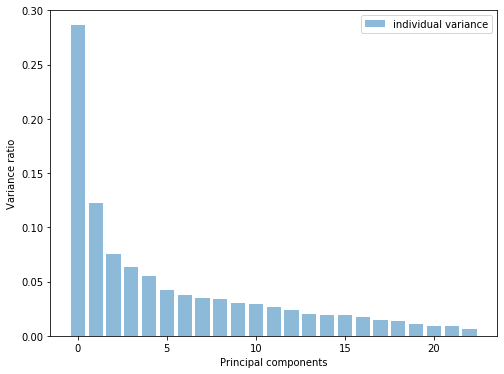

In [342]:
plt.figure(figsize=(8, 6))
plt.bar(range(len(x_pca.columns)), explained_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

### Check linear regression plots

Text(0.5, 1.0, 'KNPrice')

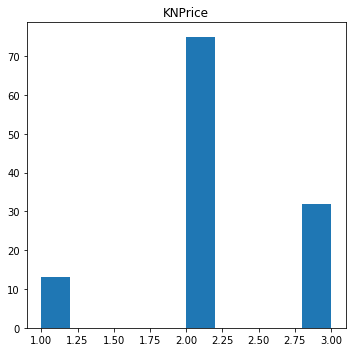

In [224]:
variable_index = variable_list.index('KNPrice') #Just enter the variable name you want an output for 

variable_name = variable_list[variable_index]

fig, axs = plt.subplots(figsize=(5,5),sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs.hist(survey_cam_merge[variable_name])
axs.set_title(f'{variable_name}')

Create output of assumption test
peirce test of normality for indep variable
ind:
dv:

In [482]:
#Are these switched?
survey_dependent = survey_df_analysis[dependent_list]
survey_network = survey_df_analysis[network_list]
survey_c1 = survey_df_analysis[control_list_1]


In [519]:
print(list(survey_network.columns))
survey_cent = survey_network.iloc[:,[6,13]]

['Prolific1', 'node_count', 'positive_nodes', 'negative_nodes', 'neutral_nodes', 'edge_count', 'density', 'diameter', 'triadic_closure', 'central_node', 'central_node_title', 'central_node_val', 'central_node_val_eig', 'central_node_val_bet']


In [520]:
#For all the below graphs:
y = survey_dependent
X = survey_cent

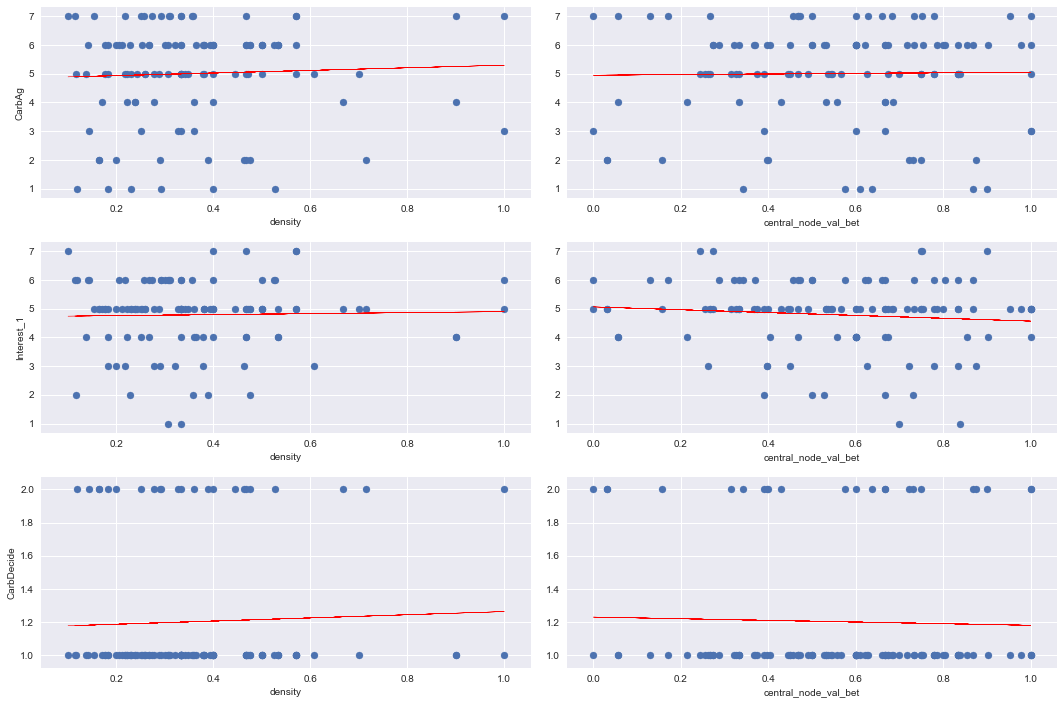

In [521]:
import scipy.stats as st
fig, axes = plt.subplots(nrows=len(y.columns), ncols=len(X.columns), figsize=(15, 10))
                                   
for i in range(len(y.columns)):
    for j in range(len(X.columns)):
        axes[i, j].scatter(X.iloc[:,j],y.iloc[:,i])
        axes[i,j].set_xlabel(f'{X.columns[j]}',fontsize=10)
        
        
        slope, inter, r, p, std_err = st.linregress(X.iloc[:,j],y.iloc[:,i])
        plot_fit = slope * (X.iloc[:,j]) + inter
        axes[i,j].plot((X.iloc[:,j]),plot_fit,linestyle='solid',color="red",lw=.3)
        
        if j ==0:
            axes[i,j].set_ylabel(f'{y.columns[i]}',fontsize=10)
            
fig.tight_layout()


#### Data transformations?

boxcox shorthand:
lambda = -1. is a reciprocal transform.
lambda = -0.5 is a reciprocal square root transform.
lambda = 0.0 is a log transform.
lambda = 0.5 is a square root transform.
lambda = 1.0 is no transform.

In [504]:
from scipy.stats import boxcox
data = boxcox(y.iloc[:,1], 0)
data

array([-0.51919387, -0.47320876, -0.5691612 , -0.75289718, -0.75502258,
       -0.34672461, -0.73605468, -0.75077629, -0.50583808, -0.63487827,
       -0.56036607, -0.77002822, -0.68121861, -0.82098055, -0.66358838,
       -0.63487827, -0.614336  , -0.491023  , -0.4975804 , -0.77435724,
       -0.73396918, -0.73396918, -0.73396918, -0.50418108, -0.5464528 ,
       -0.34672461, -0.70319752, -0.72567037, -0.50916034, -0.80519668,
       -0.45255672, -0.44472582, -0.50418108, -0.69314718, -0.7072461 ,
       -0.48613301, -0.5464528 , -0.46840491, -0.36528332, -0.70927656,
       -0.60880603, -0.74023879, -0.51751461, -0.7985077 , -0.84397007,
       -0.46521511, -0.34672461, -0.54300452, -0.73188801, -0.61803971,
       -0.74654796, -0.74023879, -0.37396644, -0.73396918, -0.75928698,
       -0.54991301, -0.78088609, -0.62362112, -0.67138569, -0.69916525,
       -0.68517901, -0.43540898, -0.48450832, -0.53956809, -0.55861629,
       -0.61618614, -0.77219039, -0.67334455, -0.77219039, -0.34

#### Assumption Testing for OLS

In [433]:
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [497]:
unique_values = survey_dependent.iloc[:,0].unique()
unique_values

array([6., 2., 3., 1., 7., 5., 4.])

In [522]:
X = survey_cent
X = sm.add_constant(X)
y = survey_dependent.iloc[:,0]

# generate OLS model
model = sm.OLS(y, X)
model_fit = model.fit()
# create dataframe from X, y for easier plot handling
dataframe = pd.concat([X, y], axis=1)

In [523]:
X.head()

,const,density,central_node_val_bet
0,1.0,0.476,0.667
1,1.0,0.393,0.786
2,1.0,0.200,0.722
3,1.0,0.143,0.667
4,1.0,0.182,0.636


In [524]:
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 CarbAg   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.1979
Date:                Fri, 19 Feb 2021   Prob (F-statistic):              0.821
Time:                        13:35:41   Log-Likelihood:                -219.12
No. Observations:                 113   AIC:                             444.2
Df Residuals:                     110   BIC:                             452.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.6374 

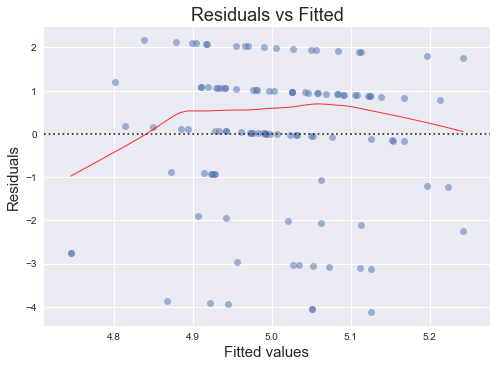

In [525]:
# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

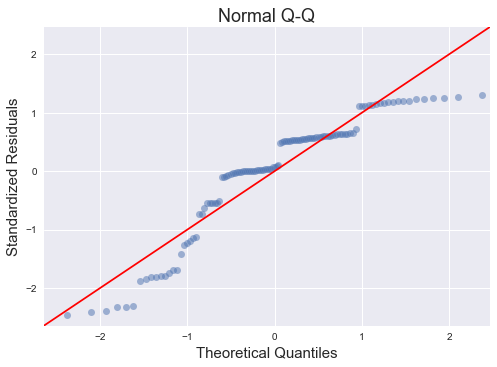

In [526]:
#further from line = errors not being normally distributed
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');




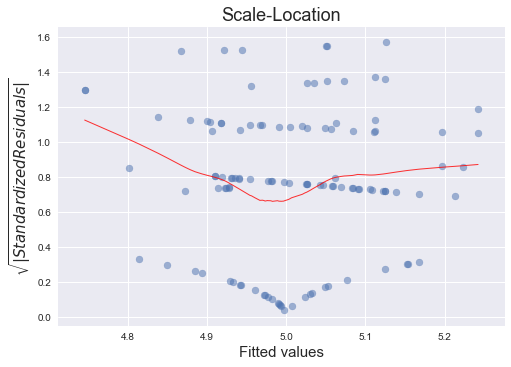

In [527]:
#The more horizontal the red line is, the more likely the data is homoscedastic
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');



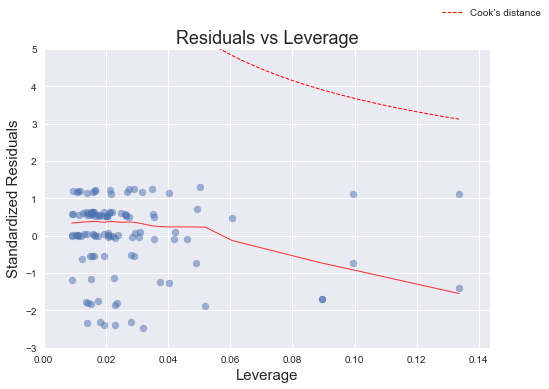

In [528]:
#Cook’s Distance, we only need to find leverage points that have a distance greater than 0.5 (above dotted red line). 

plot_lm_4 = plt.figure();
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
sns.regplot(model_leverage, model_norm_residuals,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

# shenanigans for cook's distance....not sure this is right 
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

# annotations


p = len(model_fit.params) # number of model parameters
graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
    np.linspace(0.001, max(model_leverage), 50),
    'Cook\'s distance') # 0.5 line

#graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
    #np.linspace(0.001, max(model_leverage), 50)) # 1 line

plot_lm_4.legend(loc='upper right');

## GLM

In [ ]:
from patsy import dmatrices
import statsmodels.api as sm

formula = """dep ~ ind1 + C(ind2_catagorical) )"""

response, predictors = dmatrices(formula, data, return_type='dataframe')
po_results = sm.GLM(response, predictors, family=sm.families.Poisson()).fit()
print(po_results.summary())

In [ ]:
# Poisson regression code
import statsmodels.api as sm

exog, endog = sm.add_constant(x), y

mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log))

res = mod.fit()

# Coor Analysis

create a clustering coef.
net measure predicts feelings about carbon tax
show optimal binning variable